In [1]:
import nibabel as nib
import os
import numpy as np
import os.path as op
import seaborn as sns
import glob
import matplotlib
import scipy
import matplotlib.pyplot as plt
import pandas as pd
from nipype.interfaces import fsl
from statsmodels.formula.api import ols
import statsmodels.api as sm 
import statsmodels.formula.api as smf
%matplotlib inline

/home/iballard/anaconda/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/iballard/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
#preliminary housekeeping
home_dir = '/data/home/iballard/fd/'
subj_file = home_dir + 'subjects.txt'
subs = list(np.loadtxt(subj_file,'string'))
os.chdir(home_dir)

In [16]:
exp = 'sim_4mm-PEdiffone'
smooth = 'smoothed'
masks = ['sim_4mm_striatum_PE_mf_mask']

contrasts = ['PE_mb','PE_mf']
contrast_map = {'PE_mb': '15', 'PE_mf': '14'}

In [17]:
copes = {'sub':[],'mask':[],'run':[],'contrast':[],'cope':[]}

for m in masks:
    for contrast in contrasts:
        for sub in subs:
            #load ROI
            mask = op.join(home_dir,'data', sub,  'masks', m + '.nii.gz')
            mask = nib.load(mask).get_data().astype(bool)

            sub_dir = op.join(home_dir,'analysis', exp, sub,'reg','epi',smooth)
            runs = glob.glob(sub_dir + '/run*')
            for run in runs:

                #load stat image
                stat = op.join(run, 'cope' + contrast_map[contrast] + '_xfm.nii.gz')
                stat = nib.load(stat).get_data().astype(float)

                #mask
                stat = stat[mask]

                copes['sub'].append(sub)
                copes['mask'].append(m)
                copes['run'].append(run[-1])
                copes['contrast'].append(contrast)
                copes['cope'].append(np.nanmean(stat))
copes = pd.DataFrame(copes)

In [27]:
err = []
for c in contrasts:
    contrast = copes.set_index('contrast').loc[c]
    model_str = 'cope ~ 1'
    mixedfx = smf.mixedlm(model_str, contrast, groups = contrast['sub'])    
    mixedfx = mixedfx.fit()
    print c
    print mixedfx.summary()
    print mixedfx.tvalues
    e =  mixedfx.bse['Intercept']
    dz = mixedfx.params['Intercept'] / (e * np.sqrt(len(subs)))
    print 'dz',dz
    err.append(e)

PE_mb
          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: cope       
No. Observations: 94      Method:             REML       
No. Groups:       32      Scale:              220522.6679
Min. group size:  2       Likelihood:         -714.9661  
Max. group size:  3       Converged:          Yes        
Mean group size:  2.9                                    
---------------------------------------------------------
             Coef.   Std.Err.   z   P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept    259.349   64.054 4.049 0.000 133.805 384.894
groups RE  55848.724   89.479                            

Intercept    4.048898
groups RE    1.329119
dtype: float64
dz 0.7157508021959001
PE_mf
          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: cope      
No. Observations: 94      Method:             REML      
No. Groups:       32      Scale:              48382.3652
M

In [28]:
def remove_intercept_variance(x, group_mean):
    return x - x.mean() + group_mean

In [30]:
mb = copes[copes['contrast'] == 'PE_mb']
mb['cope_within'] = mb.groupby('sub').cope.transform(remove_intercept_variance,mb.cope.mean())
mf = copes[copes['contrast'] == 'PE_mf']
mf['cope_within'] = mf.groupby('sub').cope.transform(remove_intercept_variance,mf.cope.mean())
df = pd.concat([mb,mf])
df.to_csv('/home/iballard/Dropbox/fd/paper/data/striatum_copes.csv', index = False)

/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


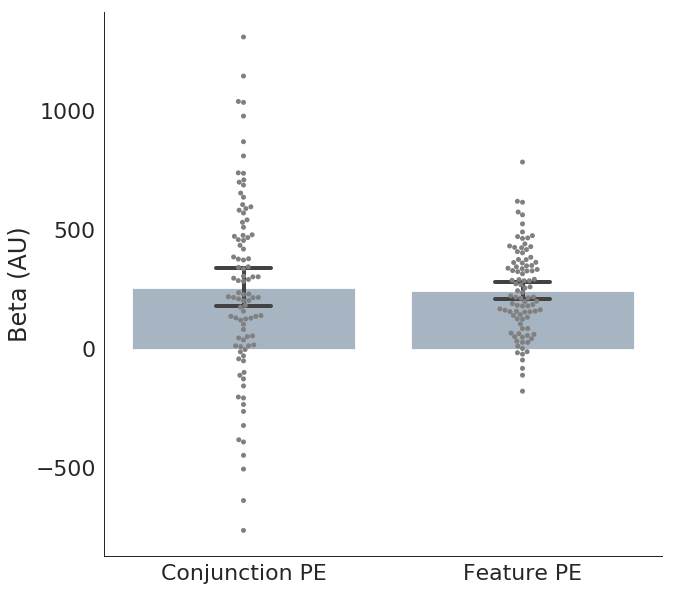

In [20]:
palette = ["#A1B6C6","#A1B6C6"]
id_map = {'PE_mb':'Conjunction PE','PE_mf':'Feature PE'}
df['contrast'] = [id_map[x] for x in df['contrast']]

sns.set_context('paper',font_scale = 2.5)
sns.set_style("white")

ax = sns.barplot(x='contrast',
                 y='cope_within',
                capsize=.2,
                 palette = palette,
                 errwidth=4,                
                 data=df)
ax = sns.swarmplot(x='contrast',
                   y='cope_within',
                   data=df,
                   color = 'grey',
                   edgecolor = 'grey'
                  )


# plt.title('Striatal Prediction Errors')
plt.ylabel('Beta (AU)')
plt.xlabel('')
sns.despine()
plt.savefig('/home/iballard/Dropbox/fd/figs/revision/mfx_striatum.png', 
            dpi = 600,
           bbox_inches = 'tight')

In [90]:
# copes.to_csv(home_dir + 'striatum_pe.csv', index = False)

# Create leave-one-subject-out masks

In [5]:
#first run n_subs 3rd levels
for sub in subs:
    other_subs = [x for x in subs if x!= sub]
    
    contrast_f = op.join(home_dir, 'analysis', 'sim_4mm-PEdiffone', 'PEdiffone-' + sub,'mni')
    if not op.exists(contrast_f):
        cmd = ['run_group.py','-e','sim_4mm','-altmodel','PEdiffone',
               '-nprocs','56','-output','PEdiffone-' + sub,s
               '-regspace','mni','-s']
        for s in other_subs:
            cmd.append(s)

        cmd = ' '.join(cmd)
#         os.system(cmd)    

In [16]:
for sub in subs:
    contrast_f = op.join(home_dir, 'analysis', 'sim_4mm-PEdiffone', 'PEdiffone-' + sub,'mni',
                        'PE_mb','zstat1.nii.gz')
    thresh = 1.65 #p<.05 
    anat_mask = op.join(home_dir, 'analysis', 'striatum',
                        'striatum_frontal_limbic.nii.gz')
    out_mask = op.join(home_dir, 'analysis', 'striatum','l1so',
                       'striatum_frontal_limbic_PE_mf_' + sub + '.nii.gz')
    
    if op.exists(contrast_f):
        
        #threshold and binarize stat mask, multiply by striatal mask, and save result
        cmd = ['fslmaths',
               contrast_f,
               '-thr',str(thresh),
               '-bin',
               '-mul',anat_mask,
               out_mask]
        os.system(' '.join(cmd))
    else: 
        print contrast_f


In [18]:
#make masks in subject functional space
for sub in subs: 
    #set paths
    mask_path = op.join(home_dir,'data',sub)
    out_dir = op.join(mask_path, 'masks')

    #copy warpfile to make ANTs happy
    warp = op.join(mask_path, 'normalization','inverse_warpfield.nii.gz')
    warpfield = op.join(mask_path, 'normalization','InverseWarp.nii.gz')
    cmd = ['ln','-s',warp, warpfield]
#     os.system(' '.join(cmd))

    #get MNI mask
    roi = 'striatum_l1so'
    im = op.join(home_dir, 'analysis', 'striatum','l1so',
                 'striatum_frontal_limbic_PE_mf_' + sub + '.nii.gz')

    #warp to subject space
    out_warp = op.join(out_dir, roi + '_anat_space.nii.gz')
    ref_file = fsl.Info.standard_image("avg152T1_brain.nii.gz")
    affine = op.join(home_dir, 'data', sub, 'normalization','affine.txt')
    anat = op.join(home_dir, 'data', sub, 'anat', 'T1_native.nii.gz')

    if os.path.exists(out_warp):
        os.remove(out_warp)
    cmd_str = ['WarpImageMultiTransform','3',im,out_warp,'-i',affine,warpfield,
               '-R',anat]
    cmd_str = ' '.join(cmd_str)
#     os.system(cmd_str)

    #register to functional space
    sub_path = op.join(home_dir, 'analysis',  exp, sub)

    #register to func
    transform = op.join(sub_path, 'preproc', 'run_1', 'func2anat_tkreg.dat')
    mean_func = op.join(sub_path, 'preproc', 'run_1', 'mean_func.nii.gz')
    out_rigid = op.join(out_dir, exp + '_' + roi + '_func_space.nii.gz')
    if os.path.exists(out_rigid):
        os.remove(out_rigid)
    cmd_line = ['mri_vol2vol','--mov',mean_func,'--targ',out_warp,'--reg',transform,'--o',out_rigid,
                '--no-save-reg','--inv']
#     os.system(' '.join(cmd_line))

    #binarize
    out_mask = op.join(out_dir, exp + '_' + roi + '_mask.nii.gz')
    if os.path.exists(out_mask):
        os.remove(out_mask)
    cmd = ['fslmaths',out_rigid,'-thr','.1','-bin',out_mask]
#     os.system(' '.join(cmd))
